<a href="https://colab.research.google.com/github/Andreher00/ml-project/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning for cell type classification from single nucleus RNA sequencing data

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Reading mouse brain dataset

In [3]:
data = pd.read_csv('/content/drive/MyDrive/progettoML/brain_counts.csv.gz')
annotations = pd.read_csv('/content/drive/MyDrive/progettoML/brain_metadata.csv')

In [4]:
annotations["cell_ontology_class"].value_counts()

oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: cell_ontology_class, dtype: int64

In [5]:
data.shape

(3401, 23434)

In [6]:
data.head()

,Unnamed: 0,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
0,A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
1,A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,...,0,0,0,0,0,195,0,0,113,0
3,A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,...,0,0,0,0,125,0,1,0,0,0
4,A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [7]:
annotations.head()

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923


In [8]:
data.index = data['Unnamed: 0']

In [9]:
data = data.drop('Unnamed: 0', axis=1)
# change index name to cell
data.index.name = 'cell'

In [10]:
data.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,0,195,0,0,113,0
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,0,125,0,1,0,0,0
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [11]:
annotations.index = annotations["cell"]

In [12]:
data= data.merge(annotations[['cell_ontology_class']], on='cell', how='inner')

In [13]:
data.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene,cell_ontology_class
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,54,0,astrocyte
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,astrocyte
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,195,0,0,113,0,oligodendrocyte
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,125,0,1,0,0,0,endothelial cell
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,81,0,0,0,0,0,0,astrocyte


In [14]:
X = data.drop('cell_ontology_class', axis=1)
y = data['cell_ontology_class']

In [15]:
data.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene,cell_ontology_class
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,54,0,astrocyte
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,astrocyte
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,195,0,0,113,0,oligodendrocyte
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,125,0,1,0,0,0,endothelial cell
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,81,0,0,0,0,0,0,astrocyte


Dividiamo il dataset in training e test, utilizzando la proporzione di default di 0.25 per la dimensione del test set.

In [16]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

Le matrici risultanti da un esperimento di single cell/nucleus RNAseq sono *sparse*, presentano cioè molti 0 dovuti al fatto che per ogni cellula solo una piccola quantità di geni viene rilevata (circa 2000-3000 rispetto ai più di 20000 totali nel genoma). Per questo, per ogni modello abbiamo inserito una feature extraction tramite PCA per ridurre la dimensionalità del dataset alle componenti responsabili per la maggiore varianza, preceduta da standardizzazione. Questo è un passaggio abituale nel preprocessing di dati di scRNAseq.

Per ogni modello definiamo una pipeline, che ci consente di applicare automaticamente il preprocessing al training e al test set evitando il data leakage, cioè l'utilizzo di informazioni presenti nel test set per il training del modello.
Per la determinazione degli iperparametri abbiamo fatto uso della funzione GridSearchCV effettuando una 5-fold cross validation per ogni combinazione di parametri.

#PIPELINE KNN

La K-Nearest Neighbors Classification è un modello non parametrico che per ogni osservazione query, determina la sua classe basandosi sulla classe a cui appartiene la maggioranza delle K osservazioni più vicine ad essa nel training set, secondo una determinata metrica (in questo caso la distanza euclidea).
Gli iperparametri che consideriamo in questo caso sono il numero K di vicini e il loro peso sulla decisione.

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
pca = PCA()
scaler = StandardScaler()
knn = KNeighborsClassifier()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])

param_grid = {
  "pca__n_components": [50, 70, 100],
  "knn__n_neighbors": [5, 10, 15],
  "knn__weights": ["uniform", "distance"], # con "uniform" ogni vicino ha lo stesso peso,
                                           # con "distance" il peso di ogni vicino dipende dalla distanza dell'osservazione query
 }

In [19]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [5, 10, 15],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [50, 70, 100]},
             verbose=3)

In [20]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print("Score on test set: ", grid.score(X_test, y_test))
estimator = grid.best_estimator_

Best parameter (CV score=0.949):
{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'pca__n_components': 70}
Score on test set:  0.9330199764982373


0.9319407085752199
                                precision    recall  f1-score   support

           Bergmann glial cell       1.00      0.30      0.46        10
                     astrocyte       0.89      0.88      0.88       112
                brain pericyte       1.00      0.92      0.96        52
              endothelial cell       0.97      0.99      0.98       170
                        neuron       0.78      0.97      0.87        78
               oligodendrocyte       0.97      0.93      0.95       375
oligodendrocyte precursor cell       0.85      0.98      0.91        54

                      accuracy                           0.93       851
                     macro avg       0.92      0.85      0.86       851
                  weighted avg       0.94      0.93      0.93       851



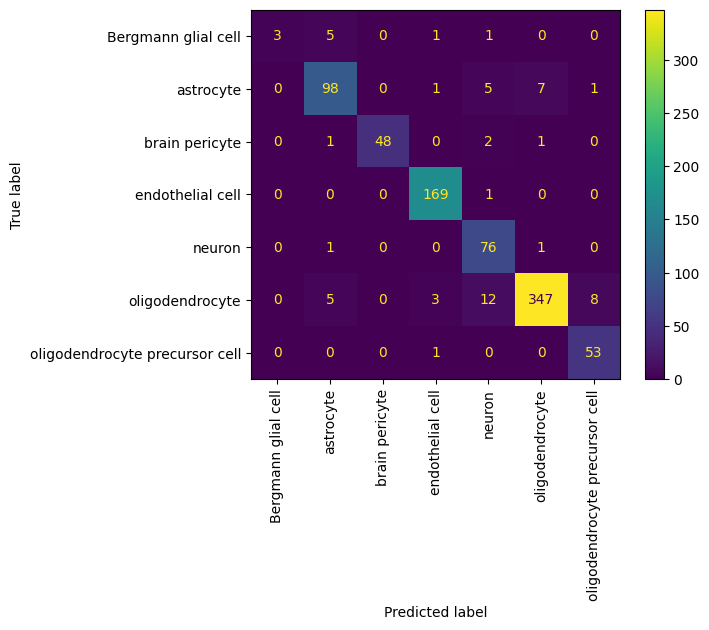

In [21]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

## KNN

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [23]:
#standardization
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

In [24]:
# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

In [25]:
# apply PCA to test set
X_test_pca = pca.transform(X_test)

In [26]:
# apply knn to predict cell type

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=11)

In [27]:
y_pred = knn.predict(X_test_pca)
print(classification_report(y_test,y_pred, zero_division=0))
print(accuracy_score(y_test,y_pred))

                                precision    recall  f1-score   support

           Bergmann glial cell       1.00      0.10      0.18        10
                     astrocyte       0.84      0.88      0.86       112
                brain pericyte       0.96      0.92      0.94        52
              endothelial cell       0.97      0.99      0.98       170
                        neuron       0.78      0.97      0.87        78
               oligodendrocyte       0.98      0.93      0.95       375
oligodendrocyte precursor cell       0.90      0.98      0.94        54

                      accuracy                           0.93       851
                     macro avg       0.92      0.82      0.82       851
                  weighted avg       0.94      0.93      0.93       851

0.9306698002350177


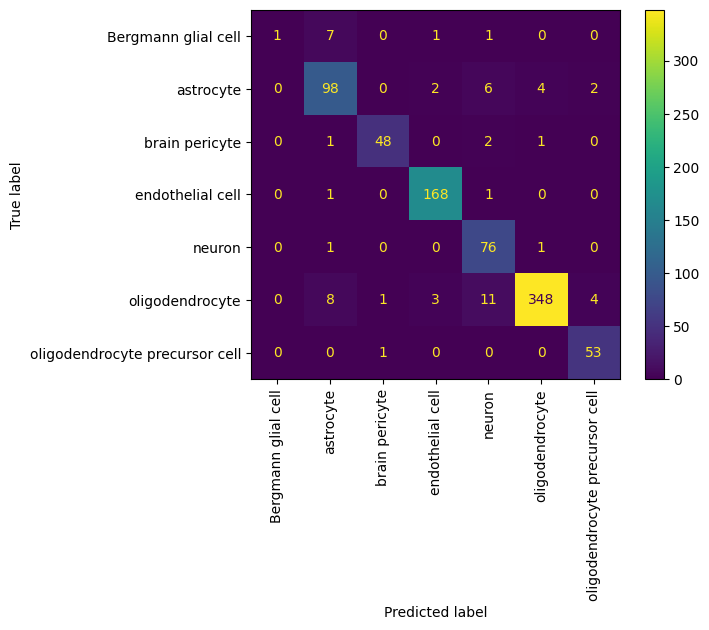

In [28]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

**Cross Validation to get the best value of K**


Text(0, 0.5, 'Accuracy Score')

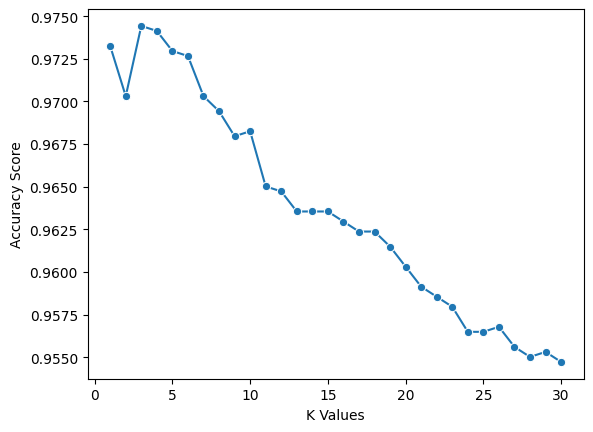

In [29]:
k_values=[i for i in range(1,31)]
scores=[]
scaler=StandardScaler()
X=scaler.fit_transform(X)
X=pca.fit_transform(X)
for k in k_values:
  knn=KNeighborsClassifier(n_neighbors=k)
  score=cross_val_score(knn,X,y, cv=5)
  scores.append(np.mean(score))
sns.lineplot(x = k_values , y= scores, marker ='o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [30]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
knn = KNeighborsClassifier(n_neighbors =best_k)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
y_pred = knn.predict (X_test_pca)

knn_accuracy =accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='micro')
recall = recall_score(y_test, y_pred,average='micro')
print("Accuracy:", knn_accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9341950646298472
Precision: 0.9341950646298472
Recall: 0.9341950646298472





# PIPELINE SVM

Una Support Vector Machine cerca di costruire un iperpiano nello spazio delle feature che abbia distanza massima dal punto più vicino nel training set (margine funzionale). Dataset non linearmente separabili possono diventarlo applicando una funzione nonlineare a ogni coppia di osservazioni (*kernel*).
Gli iperparametri che consideriamo sono il parametro di regolarizzazione C, la funzione kernel, il grado del polinomio nel caso di kernel polinomiale e il peso assegnato agli errori

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pca = PCA(n_components=50)
scaler = StandardScaler()
svm = SVC()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svm', svm)])

param_grid = {
	"svm__C": [0.01, 0.05, 0.1],
	"svm__kernel": ["linear", "rbf", "poly"],
	# "svm__degree": range(2, 6),
	"svm__class_weight": [None, "balanced"]      # Impostando questo parametro su "balanced" l'errore nella predizione di un elemento ha un peso
                                               # inversamente proporzionale alla frequenza della sua classe nel training set
}


In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
estimator = grid.best_estimator_

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

# PIPELINE RANDOM FOREST

Una Random Forest è un modello ensemble formato da una combinazione (bagging) di alberi decisionali. Ogni albero viene addestrato su un campione selezionato tramite bootstrap dal training set e la predizione finale è data dalla classe predetta dalla maggioranza degli alberi.
Gli iperparametri che consideriamo sono il numero di alberi e il peso degli errori.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pca = PCA()
scaler = StandardScaler()
rfc = RandomForestClassifier()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('rfc', rfc)])

param_grid = {
    "pca__n_components": [50, 70, 100],
    "rfc__n_estimators": [100, 150, 200],
    "rfc__class_weight": [None, "balanced"] # Impostando questo parametro su "balanced" l'errore nella predizione di un elemento ha un peso
                                            # inversamente proporzionale alla frequenza della sua classe nel training set
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

In [ ]:
grid.score(X_test, y_test)

In [ ]:

estimator = grid.best_estimator_

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, confusion_matrix
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', normalize='true')

#SENZA BERGMANN GLIAL CELL

In [ ]:
data = data[data.cell_ontology_class != 'Bergmann glial cell']
data.shape

In [ ]:
X = data.drop('cell_ontology_class', axis=1)
y = data['cell_ontology_class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## PIPELINE SVM

In [ ]:
pca = PCA(n_components=50)
scaler = StandardScaler()
svm = SVC()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svm', svm)])

param_grid = {
	"svm__C": [0.01, 0.05, 0.1],
	"svm__kernel": ["linear", "rbf", "poly"],
	# "svm__degree": range(2, 6), # degree for polynomial kernel
	"svm__class_weight": [None, "balanced"]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
estimator = grid.best_estimator_

In [ ]:
y_pred = estimator.predict(X_test)
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')